In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import random
import sys
import os
import matplotlib.pyplot as plt
import math
import scipy
from distcorr import distcorr
from fractions import gcd
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
def normal(x, mu, sigma):
    return (2.*np.pi*sigma**2.)**-.5*np.exp(-.5*(x-mu)**2./sigma**2.)

2000


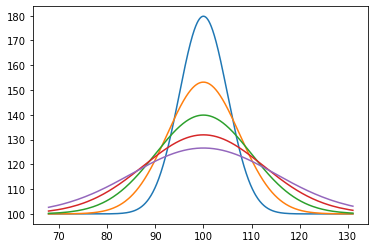

In [3]:
x = []

mu, sigma, n = 100, 10, 2000

x = np.random.normal(mu, sigma, n)
x.sort()

y = 100 + normal(x, mu, sigma*0.5)*1000
y2 = 100 + normal(x, mu, sigma*0.75)*1000
y3 = 100 + normal(x, mu, sigma*1)*1000
y4 = 100 + normal(x, mu, sigma*1.25)*1000
y5 = 100 + normal(x, mu, sigma*1.5)*1000

print(len(x))

dataset = np.vstack((x, y, y2, y3, y4, y5)).T
plt.plot(dataset[:, 0], dataset[:, 1:])



In [4]:
corr = distcorr(x, y)
corr

0.5359025895757148

In [5]:
pearson, _ = pearsonr(x, y)
pearson

0.012739379767443534

In [6]:
noise_value = 2

np.random.seed(0)
noise = np.random.normal(0, noise_value, x.shape)
noise2 = np.random.normal(0, noise_value, x.shape)
noise3 = np.random.normal(0, noise_value, x.shape)
noise4 = np.random.normal(0, noise_value, x.shape)
noise5 = np.random.normal(0, noise_value, x.shape)

y_noise = y + noise
y_noise2 = y2 + noise2
y_noise3 = y3 + noise3
y_noise4 = y4 + noise4
y_noise5 = y5 + noise5

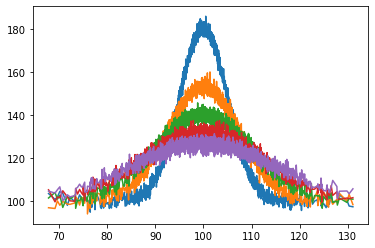

In [7]:
noised_dataset = np.vstack((x, y_noise, y_noise2, y_noise3, y_noise4, y_noise5)).T
plt.plot(noised_dataset[:, 0], noised_dataset[:, 1:])

In [8]:
NAN = 0

def fill_nan(array, REPLACE_COUNT):
    array.flat[np.random.choice(array.size, int(REPLACE_COUNT), replace=False)] = NAN

    return array

In [9]:
full_data = noised_dataset.copy()
missing_data = fill_nan(noised_dataset, noised_dataset.size*0.2)

In [10]:
bins = np.linspace(0, 10)
y_binned = np.digitize(full_data[:,0], bins)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(missing_data, full_data, stratify=y_binned, random_state=0)
x_train

array([[ 95.77383824, 157.72059967, 146.0341528 , 136.8033647 ,
        127.26215843, 124.17949954],
       [  0.        ,   0.        ,  98.42172536, 102.6964138 ,
        107.09947411, 110.66799915],
       [111.54516892, 105.72184782, 115.39639487, 124.94667099,
          0.        , 116.88260625],
       ...,
       [ 85.21760008, 102.08753082, 106.95450368, 115.05334572,
        117.58251528, 114.57244981],
       [105.2644622 , 143.61785988, 139.90536055, 134.62511141,
        130.0140069 , 124.41309501],
       [103.139489  , 162.66756828,   0.        , 137.85414916,
          0.        , 129.2222088 ]])

In [20]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = -1
NUM_FEATURES = 6
BATCH_SIZE_TEST = -1

In [13]:
x_train = torch.from_numpy(x_train)
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(y_train)
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(x_test)
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(y_test)
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([1500, 6])

In [37]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=6, out_features=8)
        self.enc2 = nn.Linear(in_features=8, out_features=16)

        self.dec2 = nn.Linear(in_features=16, out_features=8)
        self.dec3 = nn.Linear(in_features=8, out_features=6)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.dec2(x))
        x = self.dec3(x)
        return x

In [38]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(2)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [39]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [40]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=False)
    np.set_printoptions(precision=2, suppress=True)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                    print("Input: ", missing_data)
                    print("Target: ", full_data)
                    print("Outputs: ", outputs)
                else:
                    print("Input (missing): ", missing_data)
                    print("Target (missing): ", full_data)
                    print("Outputs (missing): ", outputs)
        
      #  loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        x_loss = running_loss / count
        train_loss.append(loss)



        print('Epoch {} of {}, Train Loss: {:.5f}, Overall: {:.5f}'
             .format(epoch+1, NUM_EPOCHS, x_loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        overall_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            overall_loss += loss.item()

            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                print("Input: ", missing_data)
                print("Target: ", full_data)
                print("Outputs: ", outputs)
            else:
                print("Input (missing): ", missing_data)
                print("Target (missing): ", full_data)
                print("Outputs (missing): ", outputs)

        overall_loss = overall_loss / len(x_test)
        x_loss = running_loss / count
        test_loss.append(overall_loss)
        

        return test_lossprint('Test Loss: {:.3f}, Overall: {:.5f}'.format(x_loss, overall_loss))

In [41]:
results2 = train(net)

ype=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([111.43,   0.00, 114.20, 117.60, 121.35, 119.44], dtype=torch.float64)
Target (missing):  tensor([111.43, 107.06, 114.20, 117.60, 121.35, 119.44], dtype=torch.float64)
Outputs (missing):  tensor([104.94, 105.88, 114.65, 117.79, 120.03, 119.42], dtype=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([  0.00, 110.20, 118.12, 124.53,   0.00, 121.33], dtype=torch.float64)
Target (missing):  tensor([110.22, 110.20, 118.12, 124.53, 124.32, 121.33], dtype=torch.float64)
Outputs (missing):  tensor([103.31, 109.70, 121.43, 124.72, 124.60, 123.46], dtype=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([ 94.18,   0.00, 135.44, 134.69, 125.41, 124.52], dtype=torch.float64)
Target (missing):  tensor([ 94.18, 139.17, 135.44, 134.69, 125.41, 124.52], dtype=torch.float64)
Outputs (missing):  tensor([ 93.09, 138.14, 134.88, 129.92, 126.43, 121.92], dtype=torch.float64,
       grad_fn=

In [26]:
test_result = test(net)

 119.37], dtype=torch.float64)
Target (missing):  tensor([ 92.40, 120.58, 129.46, 131.70, 125.82, 119.37], dtype=torch.float64)
Outputs (missing):  tensor([ 94.75, 119.86, 119.37, 117.10, 113.96, 112.25], dtype=torch.float64)
Input (missing):  tensor([  0.00, 181.99, 152.44, 142.46, 131.81, 126.67], dtype=torch.float64)
Target (missing):  tensor([ 99.39, 181.99, 152.44, 142.46, 131.81, 126.67], dtype=torch.float64)
Outputs (missing):  tensor([111.59, 179.57, 157.25, 145.38, 136.33, 131.32], dtype=torch.float64)
Input (missing):  tensor([ 96.59, 163.86, 143.94, 137.10, 129.36,   0.00], dtype=torch.float64)
Target (missing):  tensor([ 96.59, 163.86, 143.94, 137.10, 129.36, 127.79], dtype=torch.float64)
Outputs (missing):  tensor([ 97.07, 160.52, 146.98, 137.52, 129.81, 125.15], dtype=torch.float64)
Input (missing):  tensor([ 82.17,   0.00, 105.71, 107.98, 111.57,   0.00], dtype=torch.float64)
Target (missing):  tensor([ 82.17,  99.78, 105.71, 107.98, 111.57, 114.87], dtype=torch.float64)

In [27]:
torch.save(net, './model4')

In [28]:
predicted_set = net(x_test.double())
predicted_set = predicted_set.detach().numpy()
predicted_set

array([[ 78.24,  98.13,  99.8 ,  99.45,  97.65,  96.13],
       [106.66, 138.85, 131.17, 126.11, 121.64, 118.88],
       [ 93.15, 124.51, 126.01, 123.79, 120.56, 117.87],
       ...,
       [118.32, 101.13, 104.83, 107.81, 107.86, 108.94],
       [108.3 , 141.48, 137.38, 133.09, 127.4 , 125.86],
       [ 96.39, 135.47, 134.97, 131.73, 127.09, 124.22]])

In [29]:
real_values = []
predicted_values = []
x_values = []

for missing_data, full_data, predicted in zip(x_test, y_test, predicted_set):
    if NAN in missing_data:
        for i in range(len(missing_data)):
            if missing_data[i] == NAN:
                x_values.append(full_data[0].item())
                real_values.append(full_data[i].item())
                predicted_values.append(predicted[i].item())
print(real_values)

[99.93014029388567, 128.34659932099743, 122.09005024477534, 128.00600909437216, 77.04081262705246, 103.06766412969054, 100.54333401942577, 111.13149976325776, 138.47558607044243, 154.21633676501617, 132.75109894754777, 126.48396983299241, 121.928305899806, 119.87706321817805, 88.91431647599063, 93.79368566092289, 131.75101774528903, 127.17408156524624, 98.2981762643054, 172.55656879381996, 154.29372387150394, 136.92164581592783, 132.11781710103557, 115.53080357186383, 105.43902357738719, 109.2855081190051, 121.92066693630328, 136.00890946557797, 150.94253941707152, 133.40793717702826, 92.40390271190351, 132.54993578304635, 102.53290841063577, 150.7738204631255, 132.95479161080945, 85.75734720232731, 103.61435299400934, 115.42174257458865, 153.8304629207359, 77.83295287756147, 160.2682081763852, 127.7372292990396, 107.18733787418142, 95.39536942732516, 125.24499710004963, 113.89246593154601, 152.2140934388051, 125.60468294873183, 121.16462351887783, 121.23068233514253, 103.9128603053965

In [30]:
from scipy import stats
from statsmodels.stats import weightstats as stets

ttest, pval = stats.ttest_ind(real_values, predicted_values)
print("P-value for significance: ", pval)
print("TTEST: ", ttest)

if pval.any()<0.05:
    print("Conclusion: Reject Null Hypothesis")
else:
    print("Conclusion: Accept Null Hypothesis")

P-value for significance:  0.1409770113142768
TTEST:  1.4731680576288175
Conclusion: Accept Null Hypothesis


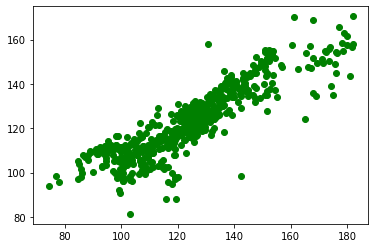

In [31]:
plt.scatter(real_values, predicted_values, color='green')
plt.show()

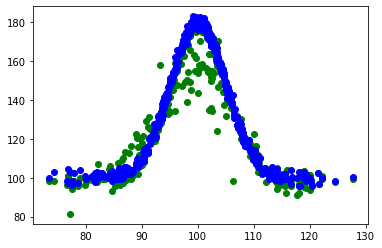

In [32]:
plt.scatter(y_test[:,0], predicted_set[:, 1], color='green')
plt.scatter(y_test[:,0], y_test[:, 1], color='blue')
plt.show()

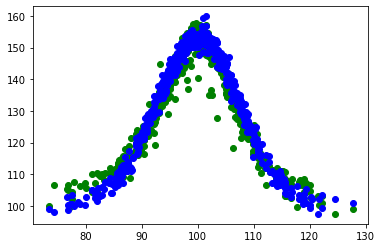

In [33]:
plt.scatter(y_test[:, 0], predicted_set[:, 2], color='green')
plt.scatter(y_test[:, 0], y_test[:, 2], color='blue')
plt.show()

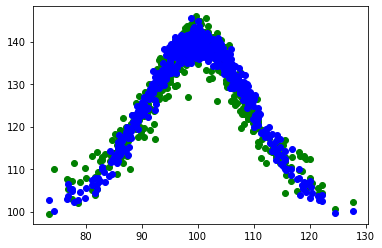

In [34]:
plt.scatter(y_test[:,0], predicted_set[:, 3], color='green')
plt.scatter(y_test[:,0], y_test[:, 3], color='blue')
#plt.fill_between(y_test[:,0], predicted[:, 2], y_test[:, 2], color='grey', alpha=0.5)
plt.show()

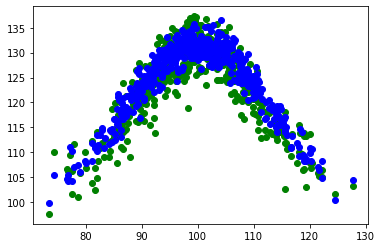

In [35]:
plt.scatter(y_test[:,0], predicted_set[:, 4], color='green')
plt.scatter(y_test[:,0], y_test[:, 4], color='blue')
#plt.fill_between(y_test[:,0], predicted[:, 2], y_test[:, 2], color='grey', alpha=0.5)
plt.show()

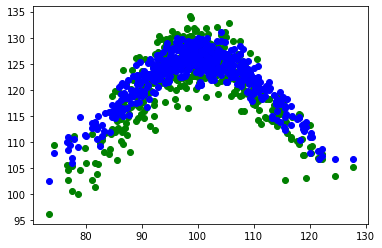

In [36]:
plt.scatter(y_test[:,0], predicted_set[:, 5], color='green')
plt.scatter(y_test[:,0], y_test[:, 5], color='blue')
#plt.fill_between(y_test[:,0], predicted[:, 2], y_test[:, 2], color='grey', alpha=0.5)
plt.show()